In [6]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.cross_validation import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score


## for Deep-learning:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout



/home/dronny/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [7]:
# getting the data 
df = pd.read_csv('austin_waste_and_diversion.csv', sep=',', 
                 parse_dates={'lt' : ['load_time']}, infer_datetime_format=True,  
                 low_memory=False, na_values=['nan','?'], index_col='lt')

In [9]:
df.head(10)

,dropoff_site,load_id,load_type,load_weight,report_date,route_number,route_type
lt,,,,,,,
2009-05-27 12:55:00,MRF,328118,RECYCLING - SINGLE STREAM,4060.0,2009-05-27,DW1,RECYCLING - SINGLE STREAM
2008-12-16 10:55:00,BRAKER SITE,308336,SWEEPING,NaN,2008-12-16,NW10-R,STREET CLEANING-RESIDENTIAL
2012-09-06 13:56:00,TDS - MRF,541514,RECYCLING - SINGLE STREAM,5060.0,2012-09-06,RHBU20,RECYCLING - SINGLE STREAM
2016-03-14 07:56:00,TDS LANDFILL,689059,SWEEPING,3720.0,2016-03-14,DSS04,SWEEPER DUMPSITES
2004-12-02 15:29:00,HORNSBY BEND,108272,YARD TRIMMING,13840.0,2004-12-02,YH08,YARD TRIMMINGS
2007-08-02 15:58:00,MRF,238174,RECYCLING - COMINGLE,2180.0,2007-08-02,RH13,RECYCLING
2006-02-15 12:15:00,TDS LANDFILL,165520,GARBAGE COLLECTIONS,15720.0,2006-02-15,PW12,GARBAGE COLLECTION
2005-07-25 15:00:00,TDS LANDFILL,138656,GARBAGE COLLECTIONS,13220.0,2005-07-25,PAM02,GARBAGE COLLECTION
2008-07-16 00:00:00,MRF,289079,RECYCLING - PAPER,3780.0,2008-07-16,RW13,RECYCLING


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 564403 entries, 2009-05-27 12:55:00 to 2012-09-10 10:20:00
Data columns (total 7 columns):
dropoff_site    564403 non-null object
load_id         564403 non-null int64
load_type       564403 non-null object
load_weight     504967 non-null float64
report_date     564403 non-null object
route_number    564403 non-null object
route_type      564403 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 34.4+ MB


In [11]:
df.dtypes

dropoff_site     object
load_id           int64
load_type        object
load_weight     float64
report_date      object
route_number     object
route_type       object
dtype: object

In [12]:
df.shape

(564403, 7)

In [13]:
df.describe

<bound method NDFrame.describe of                            dropoff_site  load_id                  load_type  \
lt                                                                            
2009-05-27 12:55:00                 MRF   328118  RECYCLING - SINGLE STREAM   
2008-12-16 10:55:00         BRAKER SITE   308336                   SWEEPING   
2012-09-06 13:56:00           TDS - MRF   541514  RECYCLING - SINGLE STREAM   
2016-03-14 07:56:00        TDS LANDFILL   689059                   SWEEPING   
2004-12-02 15:29:00        HORNSBY BEND   108272              YARD TRIMMING   
2007-08-02 15:58:00                 MRF   238174       RECYCLING - COMINGLE   
2006-02-15 12:15:00        TDS LANDFILL   165520        GARBAGE COLLECTIONS   
2005-07-25 15:00:00        TDS LANDFILL   138656        GARBAGE COLLECTIONS   
2008-07-16 00:00:00                 MRF   289079          RECYCLING - PAPER   
2008-02-29 11:45:00        TDS LANDFILL   267634        GARBAGE COLLECTIONS   
2017-03-22 07:40:0

In [14]:
df.head(10)

,dropoff_site,load_id,load_type,load_weight,report_date,route_number,route_type
lt,,,,,,,
2009-05-27 12:55:00,MRF,328118,RECYCLING - SINGLE STREAM,4060.0,2009-05-27,DW1,RECYCLING - SINGLE STREAM
2008-12-16 10:55:00,BRAKER SITE,308336,SWEEPING,NaN,2008-12-16,NW10-R,STREET CLEANING-RESIDENTIAL
2012-09-06 13:56:00,TDS - MRF,541514,RECYCLING - SINGLE STREAM,5060.0,2012-09-06,RHBU20,RECYCLING - SINGLE STREAM
2016-03-14 07:56:00,TDS LANDFILL,689059,SWEEPING,3720.0,2016-03-14,DSS04,SWEEPER DUMPSITES
2004-12-02 15:29:00,HORNSBY BEND,108272,YARD TRIMMING,13840.0,2004-12-02,YH08,YARD TRIMMINGS
2007-08-02 15:58:00,MRF,238174,RECYCLING - COMINGLE,2180.0,2007-08-02,RH13,RECYCLING
2006-02-15 12:15:00,TDS LANDFILL,165520,GARBAGE COLLECTIONS,15720.0,2006-02-15,PW12,GARBAGE COLLECTION
2005-07-25 15:00:00,TDS LANDFILL,138656,GARBAGE COLLECTIONS,13220.0,2005-07-25,PAM02,GARBAGE COLLECTION
2008-07-16 00:00:00,MRF,289079,RECYCLING - PAPER,3780.0,2008-07-16,RW13,RECYCLING


In [15]:

## finding all columns that have nan:

droping_list_all=[]
for j in range(0,1):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[]

In [73]:
# filling nan with mean in any columns

for j in range(0,1):     
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())


In [74]:
df.isnull().sum()

load_weight    0
dtype: int64

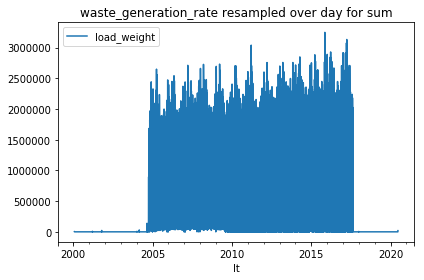

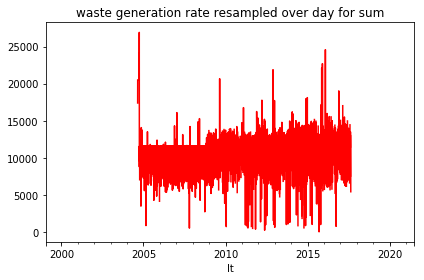

In [75]:
df.resample('D').sum().plot(title='waste_generation_rate resampled over day for sum') 
#df..resample('D').mean().plot(title='waste generation rate resampled over day', color='red') 
plt.tight_layout()
plt.show()   

df.load_weight.resample('D').mean().plot(title='waste generation rate resampled over day for sum', color='red') 
plt.tight_layout()
plt.show()

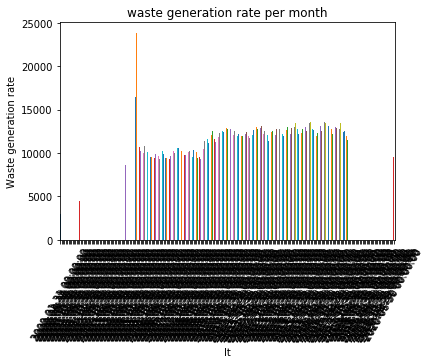

In [45]:

### Sum of 'waste generation rates' resampled over month

df['load_weight'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Waste generation rate')
plt.title('waste generation rate per month')
plt.show()

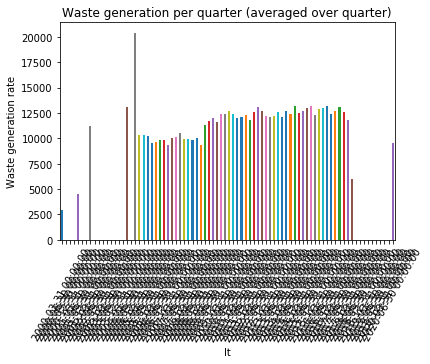

In [46]:
## Mean of 'waste generation rate' resampled over quarter
df['load_weight'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Waste generation rate')
plt.title('Waste generation per quarter (averaged over quarter)')
plt.show()


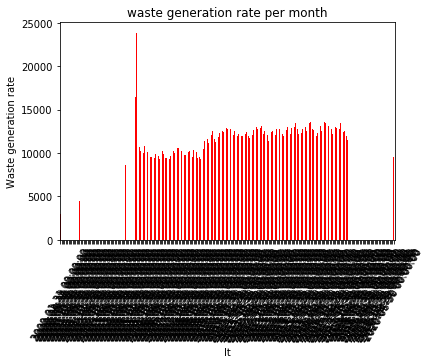

In [47]:

df['load_weight'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Waste generation rate')
plt.title('waste generation rate per month')
plt.show()

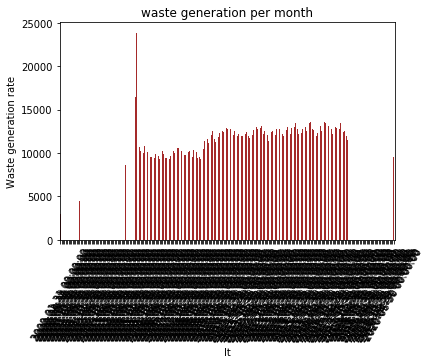

In [48]:

df['load_weight'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Waste generation rate')
plt.title('waste generation per month')
plt.show()

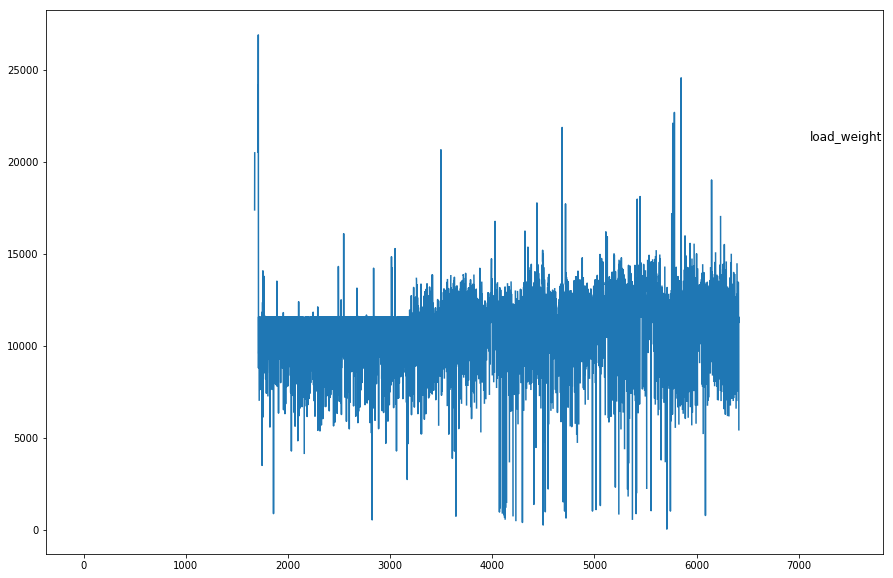

In [49]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

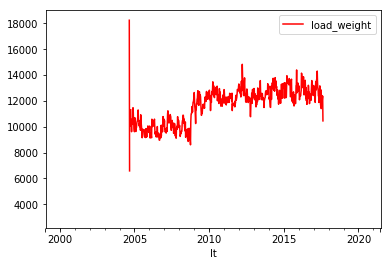

In [50]:

## resampling over week and computing mean
df.load_weight.resample('W').mean().plot(color='r', legend=True)
plt.show()

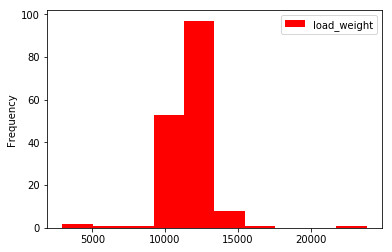

In [51]:
# Below I show hist plot of the mean of different feature resampled over month 
df.load_weight.resample('M').mean().plot(kind='hist', color='r', legend=True )

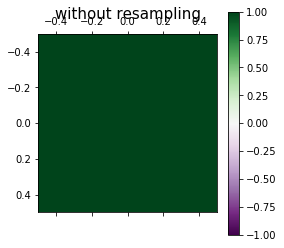

In [52]:
# Correlations among columns.
## this could be taken out. Not necessary as  I have dropped all other columns but the load weights column 
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

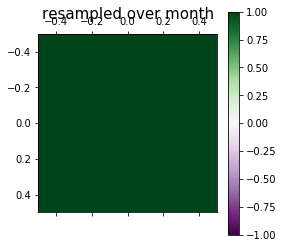

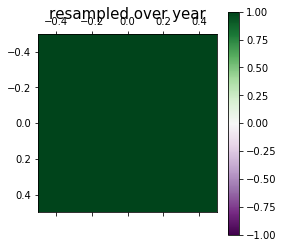

In [53]:

# Correlations of mean of features resampled over months
plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()


In [54]:
## this will reframe our waste generation time series problem into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [80]:
## inorder to reduce the computation time, let's resample our data over hour. this is to reduce the size of 
##our data to 178789 whilst still keeping the overall structure
df_resample = df.resample('h').mean() 
for i in range(0,1):
    df_resample.iloc[:,i] = df_resample.iloc[:,i].fillna(df_resample.iloc[:,i]).mean()
df_resample.head()

,load_weight
lt,
2000-01-26 12:00:00,10949.213372
2000-01-26 13:00:00,10949.213372
2000-01-26 14:00:00,10949.213372
2000-01-26 15:00:00,10949.213372
2000-01-26 16:00:00,10949.213372


In [96]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then use below
values = df_resample.values



# integer encode direction
# ensure all data is float

##values = values.astype('float64')
# normalize features
# always very important to normalise prior to training

# instantiating a MinMax scaler
scaler = MinMaxScaler(feature_range=(0,1))

# applying our scaler to our raw values to normalise them into a closed range of [0,1]
# fitting and transforming raw values
scaled = scaler.fit_transform(values)
# frame as supervised learning==> labeled taking in the normalised(scaled) features as data
reframed = series_to_supervised(scaled)
print(reframed.head())

   var1(t-1)  var1(t)
1        0.0      0.0
2        0.0      0.0
3        0.0      0.0
4        0.0      0.0
5        0.0      0.0


In [84]:
## splitting the data into training and testing sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 1) (8760,) (170028, 1, 1) (170028,)


Train on 8760 samples, validate on 170028 samples
Epoch 1/20
 - 3s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 2/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 4/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 6/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 8/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 10/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 12/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 14/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 16/20
 - 2s - loss: 0.0000e+00 - val_loss: 0.0000e+00

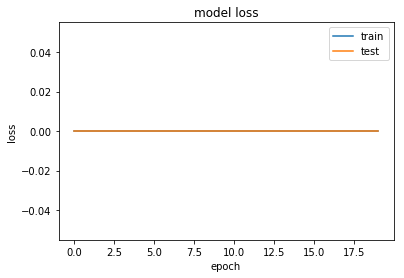

Test RMSE: 0.000


In [89]:
## building a neural network architecture.
#  then , train the model on a recurrent LSTM  with 20% dropout 

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dropout(0.2))
#model.add(LSTM(70))
#model.add(Dropout(0.3))
model.add(Dense(1)) ## a fully connected layer to cater for the prediction
model.compile(loss='mean_squared_error', optimizer='adam') # finally compile the code , using rmse loss and the adam optimizer


# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE loss. this will be optimized by our adam optimizer
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

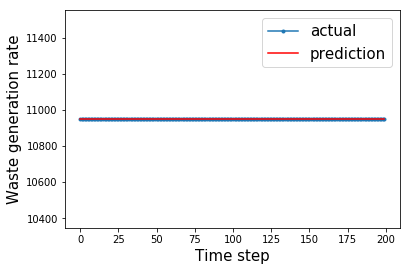

In [90]:

#Note that in order to improve the model, one has to adjust epochs and batch_size.

## time steps, every step is one hour (you can easily convert the time step to the actual time index)
## for a demonstration purpose, I only compare the predictions in 200 hours. 

aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Waste generation rate', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()
